# Modified Moby (Docker engine) Results

## Synthetic Benchmark

Benchmark used to generate system monitor logs that is designed to stress a variety of system resources, such as network, cpu, memory, and I/O

> Note: Outputs nano timestamps each command, preceded by `__N\n` where N is an incrementing hex digit

In [18]:
import parser

files = parser.get_all_files("./logs/v2", "log")
data = parser.parse_all(files)

Parsing log data from logs/v2/dockerd_2020-03-19_08:59:50.963.log... done
Parsing log data from logs/v2/dockerd_2020-03-19_21:18:31.521.log... done
Parsing log data from logs/v2/dockerd_2020-03-19_09:17:35.983.log... done


In [19]:
target_file = './logs/v2/dockerd_2020-03-19_21:18:31.521.log'
entries = data[target_file]
print()
parser.analyze_timestamps(entries)

min_ts = min(e.read for e in entries.values())

def to_s(nano_ts):
    return float(nano_ts - min_ts) / 1E9


       Read deltas (ms)
count        652.000000
mean          56.341039
std          113.454959
min           46.452881
25%           47.289062
50%           47.846680
75%           50.003113
max         2780.948975


## Timestamp Deltas

The first plot is a histogram, where a logarithmic scale used on both x and y axes. Almost all deltas are closely clustered around 50ms, with a small amount of outliers.

The second plot is a scatterplot of sequential deltas.

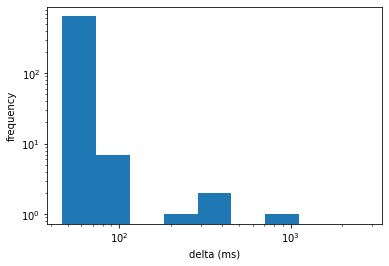

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

deltas = parser.get_ts_deltas(entries)
deltas_series = pd.Series(deltas)
plt.hist(deltas, bins=np.geomspace(deltas_series.min(), deltas_series.max(), 10))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("delta (ms)")
plt.ylabel("frequency")
plt.show()

## Overall PIT Graphs

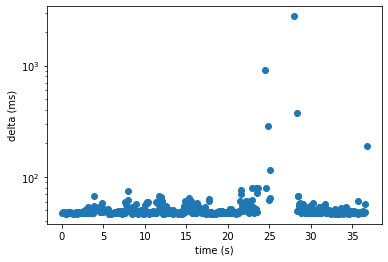

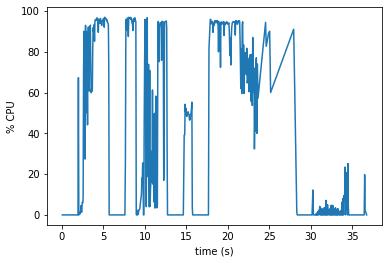

In [21]:
def cpu_per(entry):
    cpu_time = float(entry.cpu.total - entry.pre.cpu.total)
    interval = float(entry.read - entry.pre.read)
    return (cpu_time / interval) * 100

def plot_deltas(reads, deltas):
    tail = reads[1:]
    x_series = [to_s(r) for r in tail]
    y_series = deltas
    
    plt.scatter(x_series, y_series, marker='o')
    plt.yscale('log')
    plt.ylabel("delta (ms)")
    plt.xlabel("time (s)")
    plt.show()

def plot_cpu(entries):
    tail = entries[1:]
    x_series = [to_s(e.read) for e in tail]
    y_series = [cpu_per(e) for e in tail]

    plt.plot(x_series, y_series)
    plt.ylabel("% CPU")
    plt.xlabel("time (s)")
    plt.show()

    
plot_deltas([e.read for e in entries.values()], deltas)
plot_cpu(list(entries.values()))

## Period of High Load


duration of window: 12.92s
lagging % of time: 43.46%



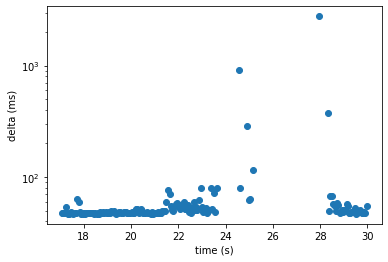

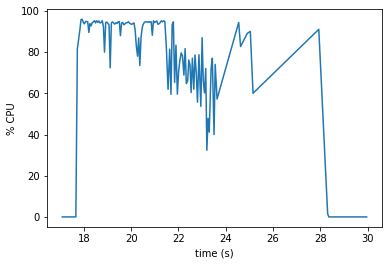

In [22]:
start_s = 17
end_s = 30

ts_list = list(entries.keys())
start = ts_list.index(list(filter(lambda i: to_s(i) > start_s, ts_list))[0])
end = ts_list.index(list(filter(lambda i: to_s(i) > end_s, ts_list))[0])

entries_window = list(entries.values())[start:end]
window = deltas[start:end]

duration = entries_window[-1].read - entries_window[0].read
print()
print("duration of window: {:.2f}s".format(float(duration) / 1E9))

above_60 = np.sum([d for d in window if d > 60])
total = np.sum(window)
lag_proportion = (above_60 / total) * 100
print("lagging % of time: {:.2f}%".format(lag_proportion))
print()

plot_deltas([e.read for e in entries_window], window[:-1])
plot_cpu(entries_window)